In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, PorterStemmer
import math
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc, mean_squared_error
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
import gensim
import string
import tensorflow as tf
import keras
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense
from keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding

from keras.layers import Dropout
import warnings
from keras import backend as K

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
!ls '/content/drive/My Drive/'
import zipfile

'Colab Notebooks'   data_comments.zip   ntu_frames.zip


In [5]:
# Path to the zipped folders
zip_file = '/content/drive/My Drive/data_comments.zip'
# Extract folder
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall('/content/folder')


In [6]:
import matplotlib.pyplot as plt

In [7]:
import pandas as pd
X_train = pd.read_pickle('/content/folder/data_comments/X_train.pkl')
X_cv = pd.read_pickle('/content/folder/data_comments/X_cv.pkl')
y_train = pd.read_pickle('/content/folder/data_comments/y_train.pkl')
y_cv = pd.read_pickle('/content/folder/data_comments/y_cv.pkl')

In [8]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
import numpy as np
import pandas as pd

class LSTMFeaturization:
    def __init__(self):
        self.word_mapping = None
        self.total_words = None

    def build_vocabulary(self, sentences):
        vocab = set()
        for x in sentences:
            for word in x.split():
                vocab.add(word)
        vocab_dict = dict.fromkeys(vocab, 0)
        for x in sentences:
            for word in x.split():
                vocab_dict[word] += 1
        return vocab_dict

    def get_mapping(self, vocab_dict):
        k = []
        v = []
        for keys, val in vocab_dict.items():
            k.append(keys)
            v.append(val)
        kv = np.vstack((k, v)).T
        df = pd.DataFrame(columns=["Word", "Count"], data=kv)
        df['Count'] = df['Count'].astype('int')
        df.sort_values(by=['Count'], ascending=False, inplace=True)
        df.reset_index(inplace=True)
        df['mapping'] = df.index + 1
        df.drop(columns=['index', 'Count'], inplace=True)
        dictionary = dict(zip(df['Word'], df['mapping']))
        return dictionary

    def fit(self, sentences):
        v = self.build_vocabulary(sentences)
        self.word_mapping = self.get_mapping(v)
        self.total_words = len(self.word_mapping)

    def transform(self, sentences, pad_length=350):
        whole = []
        for x in sentences:
            part = []
            for word in x.split():
                if word in self.word_mapping:
                    part.append(self.word_mapping[word])
            whole.append(part)
        whole = pad_sequences(whole, maxlen=pad_length)
        return whole

# Convert the 'preprocessed_text' column to strings and fill NaNs with an empty string
X_train['preprocessed_text'] = X_train['preprocessed_text'].astype(str).fillna('')
X_cv['preprocessed_text'] = X_cv['preprocessed_text'].astype(str).fillna('')

# LSTM model training
lstmfeat = LSTMFeaturization()
lstmfeat.fit(X_train['preprocessed_text'])
lstm_train = lstmfeat.transform(X_train['preprocessed_text'])
lstm_cv = lstmfeat.transform(X_cv['preprocessed_text'])

embedding_vecor_length = 100
total_words = lstmfeat.total_words

lstm_model = Sequential()
lstm_model.add(Embedding(total_words + 1, embedding_vecor_length, input_length=350))
lstm_model.add(LSTM(128, return_sequences=True))
lstm_model.add(LSTM(128))
lstm_model.add(Dense(1, activation='sigmoid'))
lstm_model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mse'])
print(lstm_model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 350, 100)          20154600  
                                                                 
 lstm (LSTM)                 (None, 350, 128)          117248    
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 20403561 (77.83 MB)
Trainable params: 20403561 (77.83 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


Epoch 1/5
661/661 [==============================] - ETA: 0s - loss: 0.0396 - mse: 0.0396
Epoch 1: val_loss improved from inf to 0.03938, saving model to best_lstm_model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


661/661 [==============================] - 346s 515ms/step - loss: 0.0396 - mse: 0.0396 - val_loss: 0.0394 - val_mse: 0.0394
Epoch 2/5
661/661 [==============================] - ETA: 0s - loss: 0.0355 - mse: 0.0355
Epoch 2: val_loss improved from 0.03938 to 0.02877, saving model to best_lstm_model.hdf5
661/661 [==============================] - 347s 525ms/step - loss: 0.0355 - mse: 0.0355 - val_loss: 0.0288 - val_mse: 0.0288
Epoch 3/5
661/661 [==============================] - ETA: 0s - loss: 0.0242 - mse: 0.0242
Epoch 3: val_loss improved from 0.02877 to 0.02136, saving model to best_lstm_model.hdf5
661/661 [==============================] - 353s 535ms/step - loss: 0.0242 - mse: 0.0242 - val_loss: 0.0214 - val_mse: 0.0214
Epoch 4/5
661/661 [==============================] - ETA: 0s - loss: 0.0195 - mse: 0.0195
Epoch 4: val_loss improved from 0.02136 to 0.01870, saving model to best_lstm_model.hdf5
661/661 [==============================] - 353s 534ms/step - loss: 0.0195 - mse: 0.0195 

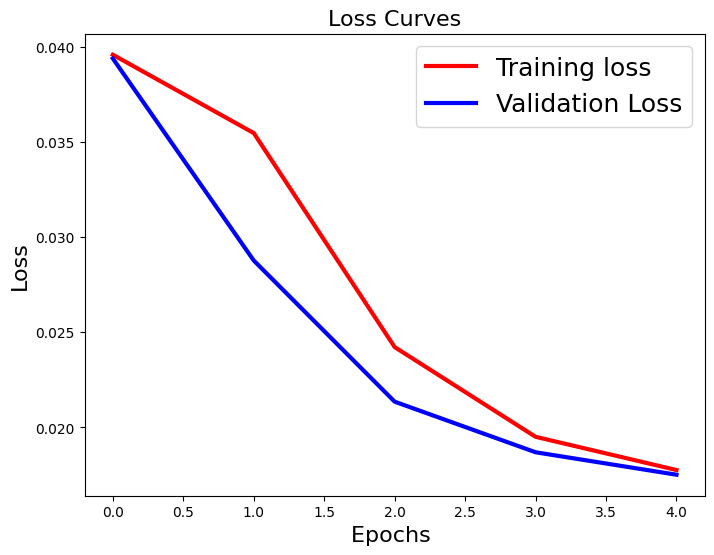

In [9]:
filepath="best_lstm_model.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

history = lstm_model.fit(lstm_train, y_train, epochs=5, batch_size=2048, validation_data=(lstm_cv, y_cv), verbose=1, callbacks=callbacks_list)

# Plot Loss Curves for LSTM
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'], fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.title('Loss Curves', fontsize=16)
plt.show()